In [ ]:
%pip install datasets einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/2 [00:00<?, ?it/s]

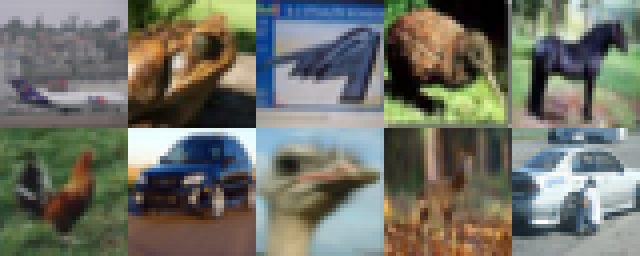

In [ ]:
# Load 10 images
from PIL import Image
from datasets import load_dataset

cifar10 = load_dataset('cifar10')
W = H = 32
cols, rows = 5, 2
img = Image.new('RGB', size=(W * cols, H * rows))
for i in range(10):
  # ignore label
  im = cifar10['train'][i]['img']
  left, top = W * (i % cols), H * (i // cols)
  img.paste(im, (left, top))
img.resize((W * cols * 4, H * rows * 4), Image.NEAREST)

In [ ]:
import torch
import math

def lin_schedule(start, end, T):
  beta = torch.linspace(start, end, steps=T)
  alpha = 1 - beta
  alpha_bar = torch.cumprod(alpha, dim=0)
  return alpha_bar

# > In particular, we
# > selected s such that \sqrt{B_0}
# > was slightly smaller than the pixel
# > bin size 1/127.5, which gives  s = 0.008
def cos_schedule(T, s = 0.008):
  alpha_bar = torch.arange(0, T)
  assert alpha_bar.shape == (T,)

  alpha_bar = ((alpha_bar / T) + s) / (1 + s)
  alpha_bar *= (math.pi / 2)
  alpha_bar = alpha_bar.cos() ** 2
  return alpha_bar

In [ ]:
# > We set T = 1000 without a sweep, and we chose a linear
# > schedule from β_1 = 10−4  to β_T = 0.02. [0]
T = 1000
lin_start = 1e-4
lin_end = 0.02

# Alternate parameters for experimentation
# The cosine schedule always starts at 1 and ends at 0
# with a smooth linear slope in the middle
# Since `alpha_bar` is a cumulative product in the linear schedule
# If we decrease the # of steps, we need to increase `lin_end` proportionally
# to end @ 0
# T = 100
# Increasing this parameter steepens the slope
# lin_start = 1e-4 
# lin_end = 0.2

# Note: Modifying T should not change the curve for the cosine schedule,
# (& if you tweak the linear schedule parameters, that curve won't change either)
# so the sample image will be degraded at the same rate

lin_alpha_bars = lin_schedule(start=lin_start, end=lin_end, T=T)
cos_alpha_bars = cos_schedule(T)

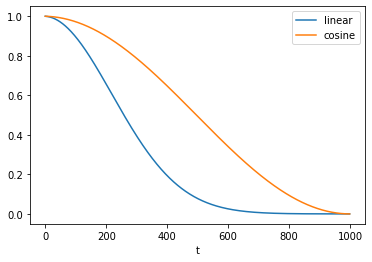

In [ ]:
import matplotlib.pyplot as plt

x = torch.arange(0, T)

plt.plot(x, lin_alpha_bars, label="linear")
plt.plot(x, cos_alpha_bars, label="cosine")
plt.xlabel("t")
plt.legend()
plt.show()

Because the cosine schedule decreases $\bar{a}$ more slowly, the co-efficient of the $\epsilon$ term increases more slowly.

Thus, noise is injected into the image more slowly.

$q(x_t|x_0) = \mathbb{N}(x_t;\sqrt{\bar{a}_t}x_0,(1-\bar{a}_t)\mathbb{I})$

$x_t = \sqrt{\bar{a}_t}x_0 + \sqrt{1 - \bar{a}_t}\epsilon$

In [ ]:
from einops import rearrange
import numpy as np

def q_xt_x0(t, x_0, abar):
  scaled = x_0 * abar[t].sqrt()
  # eps ~ N(0, I) [1]
  eps = torch.randn_like(x_0)
  noise = (1 - abar[t]).sqrt() * eps
  return scaled + noise

def img_to_tensor(img):
    scaled_0_to_1 = np.array(im.convert('RGB')) / 255
    channels_first = rearrange(scaled_0_to_1, 'h w c -> c h w')
    neg_one_to_pos_one = channels_first * 2 - 1
    return torch.tensor(neg_one_to_pos_one)

def tensor_to_image(t):
  channels_last = rearrange(t, "c h w -> h w c")
  zero_to_255 = ((channels_last + 1) / 2).clip(0, 1) * 255
  return Image.fromarray(np.array(zero_to_255).astype(np.uint8))

Image dimensions: 32x32
Tensor shape: torch.Size([3, 32, 32])


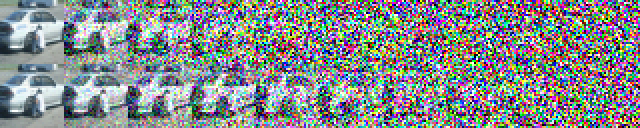

In [ ]:
sample_img = cifar10['train'][0]['img']
# sample_img = sample_img.resize((64, 64), Image.NEAREST)
print(f"Image dimensions: {sample_img.height}x{sample_img.width}")
sample_img = img_to_tensor(sample_img)
print(f"Tensor shape: {sample_img.shape}")
samples = 10

def q_samples(img, abar, samples, T):
    idxs = torch.linspace(0, T - 1, steps=samples).int()
    ims = []
    for idx in idxs:
      im = q_xt_x0(idx, img, abar)
      ims.append(im)
    return ims

def compare_schedules(img, samples, T, abars):
  all_samples = []
  for abar in abars:
    all_samples.append(q_samples(img, abar, samples, T))

  _, W, H = img.shape
  image = Image.new('RGB', size=(W*samples, H * len(abars)))
  for row, schedule_samples in enumerate(all_samples):
    for col, sample in enumerate(schedule_samples):
      sample = tensor_to_image(sample)
      image.paste(sample, (W * col, H * row))
  return image

comparison = compare_schedules(sample_img, samples, T, [lin_alpha_bars, cos_alpha_bars])
W, H = comparison.width, comparison.height
# TODO: This looks a bit suspicious. Specifically,
# it seems the car is getting destroyed a bit too quickly in both schedules
# BUT, this might just be because the car image is low resolution
comparison.resize((W*2, H*2), Image.NEAREST)

$$
p_\theta(x_{t-1}|x_t) := \mathcal{N}(x_{t-1};\mu_\theta(x_t,t),\Sigma_\theta(x_t,t))
$$

The original paper didn't learn the variance. It just fixed it to $\sigma^2_t\bf{I}$ where $\sigma^2_t$ could either be 
- $\beta_t$ (the upper bound)
- $\tilde{\beta_t}$ (the lower bound)

where $\tilde{\beta_t}$ represents the accumulated variance.

$$
\tilde{\beta_t} = \frac{1-\bar{a}_{t-1}}{1-\bar{a}_t} \cdot \beta_t
$$

and

$$
\beta_t = 1 - \frac{\bar{a}_t}{\bar{a}_{t-1}}
$$

In [ ]:
from torch import testing

# Testing my implementation of alpha_bar vs OpenAI's

# OpenAI code
def cos_alpha_bar(t):
  return math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

# My code
def cos_schedule_inclusive(T, s = 0.008):
  alpha_bar = torch.arange(0, T + 1)
  assert alpha_bar.shape == (T + 1,)

  alpha_bar = ((alpha_bar / T) + s) / (1 + s)
  alpha_bar *= (math.pi / 2)
  alpha_bar = alpha_bar.cos() ** 2
  return alpha_bar

def beta_and_agg_beta(alpha_bar, max_beta=0.999):
  betas = []
  for i in range(len(alpha_bar) - 1):
    a_next = alpha_bar[i + 1]
    a = alpha_bar[i]
    betas.append(min(1 - a_next / a, max_beta))
  return np.array(betas)

  # From the cos vs lin alpha_bar plot we see alpha_bar starts @ 1 and heads to 0
  alphas_bar_prev = alpha_bar.numpy() #np.append(1.0, alpha_bar[:-1])
  alphas_bar_next = np.append(alpha_bar[1:], 0.0)

  beta = 1 - (alphas_bar_next / alphas_bar_prev)
  beta = beta.clip(max=max_beta)
  agg_beta = beta * ((1 - alphas_bar_prev) / (1 - alphas_bar_next))
  return beta, agg_beta

# Testing code
for T in [100, 1000]:
  # Tweaking s from 0.008 causes testing to throw an error (which is good)
  my_cos_alpha_bar = cos_schedule_inclusive(T, s = 0.008).tolist()
  openai_cos_alpha_bar = [cos_alpha_bar(i / T) for i in range(T + 1)]

  my_cos_alpha_bar = cos_schedule(T, s = 0.008).tolist()
  openai_cos_alpha_bar = [cos_alpha_bar(i / T) for i in range(T)]

  manual_test = False
  if manual_test:
    i = 10
    print(openai_cos_alpha_bar[i] - my_cos_alpha_bar[i])

  testing.assert_close(openai_cos_alpha_bar, my_cos_alpha_bar)

  openai_betas = betas_for_alpha_bar(T, cos_alpha_bar)
  def from_list(l, x):
    idx = x * T
    return l[int(idx)]
  #my_betas = betas_for_alpha_bar(T, lambda x: from_list(openai_cos_alpha_bar, x))
  #my_betas = beta_and_agg_beta(my_cos_alpha_bar)
  #assert len(my_betas) == len(openai_betas)
  #print(openai_betas[2] - my_betas[3])
  #testing.assert_close(openai_betas, my_betas)


AssertionError: ignored

[0.         0.08168025 0.22458027 0.34069681 0.4299188  0.49920703
 0.55414538 0.59861887 0.63529592 0.66603655 0.69216513 0.71464547
 0.73419357 0.75135137 0.76653608 0.78007382 0.79222303 0.80319102
 0.81314602 0.82222589 0.83054467 0.83819748 0.84526431 0.85181288
 0.85790089 0.86357785 0.86888643 0.87386364 0.87854171 0.88294886
 0.88710988 0.89104666 0.89477859 0.89832291 0.901695   0.90490861
 0.90797612 0.91090863 0.91371619 0.9164079  0.918992   0.92147598
 0.9238667  0.9261704  0.9283928  0.93053915 0.93261427 0.93462262
 0.93656827 0.93845504 0.94028642 0.94206566 0.94379579 0.94547962
 0.94711976 0.94871866 0.95027861 0.95180173 0.95329003 0.95474539
 0.95616956 0.95756422 0.95893093 0.96027116 0.9615863  0.96287768
 0.96414654 0.96539406 0.96662137 0.96782954 0.96901959 0.97019248
 0.97134914 0.97249045 0.97361727 0.9747304  0.97583061 0.97691867
 0.97799528 0.97906115 0.98011694 0.9811633  0.98220085 0.98323021
 0.98425197 0.9852667  0.98627495 0.98727728 0.98827422 0.9892

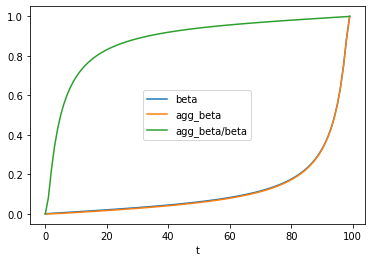

In [ ]:
def cos_alpha_bar(t):
  return math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2

def cos_betas(T):
        return betas_for_alpha_bar(
            T,
            cos_alpha_bar
        )


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

def agg_betas(beta):
  alpha = 1 - beta
  alpha_bar = alpha.cumprod(axis=0)
  alpha_bar_prev = np.append(1.0, alpha_bar[:-1])
  alpha_bar_next = np.append(alpha_bar[1:], 0.0)
  agg_beta = beta * ((1 - alpha_bar_prev) / (1 - alpha_bar_next))
  return agg_beta 


# Plot B_t, agg_B_t, and their ratio
# agg_B_t = \tilde{\beta_t}

# For some reason, this method
def beta_and_agg_beta(alpha_bar):
  # From the cos vs lin alpha_bar plot we see alpha_bar starts @ 1 and heads to 0
  alphas_bar_prev = np.append(1.0, alpha_bar[:-1])
  alphas_bar_next = np.append(alpha_bar[1:], 0.0)

  beta = 1 - (alphas_bar_next / alphas_bar_prev)
  agg_beta = beta * ((1 - alphas_bar_prev) / (1 - alphas_bar_next))
  # print(beta - agg_beta)
  return beta, agg_beta

T = 100
cos_alpha_bars = cos_schedule(T)
cos_alpha_bars = [cos_alpha_bar(i / T) for i in range(T)]
for i, x in enumeratecos_alpha_bars:

beta = cos_betas(T)
agg_beta = agg_betas(beta)
beta, agg_beta = beta_and_agg_beta(cos_alpha_bars)
#cos_alpha_bars = cos_schedule(T)
# beta, agg_beta = beta_and_agg_beta(cos_alpha_bars)
# beta = betas2(T)
# print(beta - agg_beta)
ratio = agg_beta / beta
print(ratio[:100])

x = torch.arange(0, T)
plt.xlabel("t")
plt.plot(x, beta, label="beta")
plt.plot(x, agg_beta, label="agg_beta")
plt.plot(x, ratio, label="agg_beta/beta")
plt.legend()
plt.show()